# Imports

In [1]:
from pyts.datasets import load_gunpoint
from pyts.image import RecurrencePlot

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary

torch.manual_seed(41)

from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [2]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)

# Preparation of Dataset

In [3]:
X_test, X_train, y_test, y_train = load_gunpoint(return_X_y=True)

In [4]:
X_train.shape

(150, 150)

In [5]:
y_train.shape

(150,)

In [6]:
X_test.shape

(50, 150)

In [7]:
y_test.shape

(50,)

In [8]:
df = pd.DataFrame(X_train)

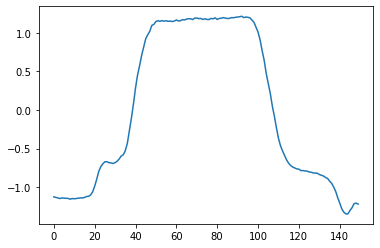

In [9]:
df.iloc[0, :].plot.line();

In [10]:
y_train = np.where(y_train == 2, 0, y_train)
y_test = np.where(y_test == 2, 0, y_test)

# Application of `RecurrencePlot`

In [11]:
transformer = RecurrencePlot()
X_train_new = transformer.transform(X_train)
X_test_new = transformer.transform(X_test)

In [12]:
X_train_new.shape

(150, 150, 150)

In [13]:
y_train

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

In [14]:
y_train_0 = np.where(y_train == y_train.min())[0]
y_train_0

array([  1,   2,   5,   7,   8,  12,  17,  18,  19,  21,  25,  28,  31,
        32,  39,  41,  44,  46,  47,  49,  50,  51,  53,  56,  57,  59,
        61,  64,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  82,  83,  84,  85,  87,  91,  93,  96,  97, 100, 103, 104,
       107, 109, 110, 111, 113, 116, 119, 121, 122, 123, 125, 128, 129,
       130, 131, 135, 137, 140, 143, 145, 147, 148], dtype=int64)

In [15]:
y_train_1 = np.where(y_train == y_train.max())[0]
y_train_1

array([  0,   3,   4,   6,   9,  10,  11,  13,  14,  15,  16,  20,  22,
        23,  24,  26,  27,  29,  30,  33,  34,  35,  36,  37,  38,  40,
        42,  43,  45,  48,  52,  54,  55,  58,  60,  62,  63,  65,  66,
        79,  80,  81,  86,  88,  89,  90,  92,  94,  95,  98,  99, 101,
       102, 105, 106, 108, 112, 114, 115, 117, 118, 120, 124, 126, 127,
       132, 133, 134, 136, 138, 139, 141, 142, 144, 146, 149], dtype=int64)

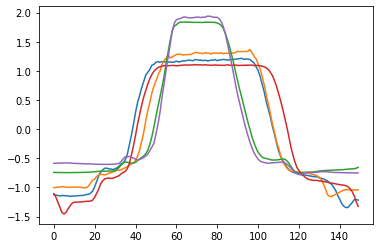

In [16]:
for idx_1 in y_train_1.tolist()[:5]:
    df.iloc[idx_1, :].plot.line();

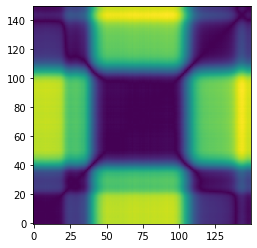

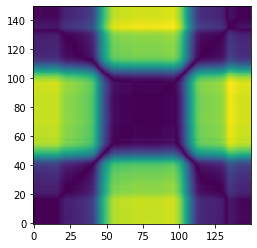

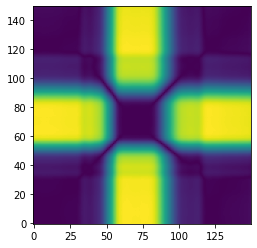

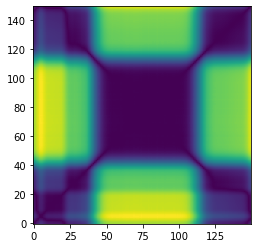

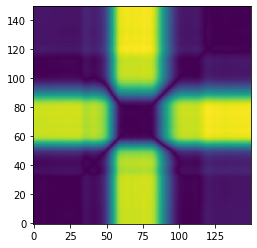

In [17]:
for idx_1 in y_train_1.tolist()[:5]:
    plt.imshow(X_train_new[idx_1], origin='lower')
    plt.show();

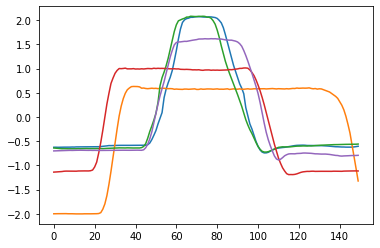

In [18]:
for idx_0 in y_train_0.tolist()[:5]:
    df.iloc[idx_0, :].plot.line();

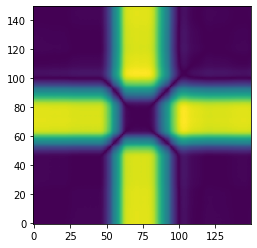

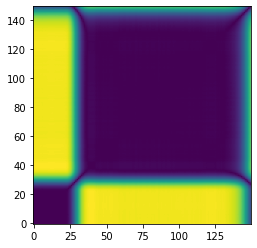

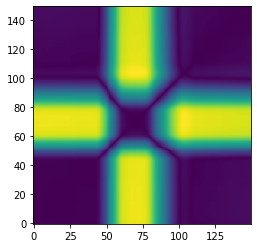

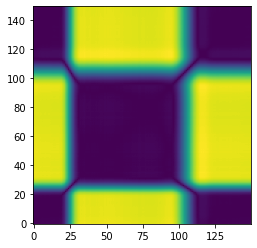

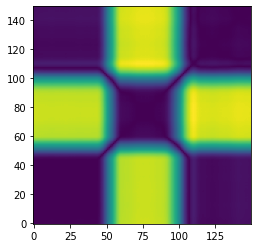

In [19]:
for idx_0 in y_train_0.tolist()[:5]:
    plt.imshow(X_train_new[idx_0], origin='lower')
    plt.show();

# Preparation of Dataloader

In [20]:
X_train_tensor = torch.Tensor(X_train_new)
X_train_tensor = X_train_tensor.unsqueeze(1)
y_train_tensor = torch.Tensor(y_train)

X_test_tensor = torch.Tensor(X_test_new)
X_test_tensor = X_test_tensor.unsqueeze(1)
y_test_tensor = torch.Tensor(y_test)

In [21]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(train_dataset, batch_size=15, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
validloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# Preparation for CNN

In [22]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 3, (3, 3), padding=1),         # 3, 150 x 150
            nn.ReLU(),
            nn.MaxPool2d((10, 10)),                        # 3, 15 x 15
            #nn.Dropout(0.2),
            nn.Conv2d(3, 1, (3, 3), padding=1),         #  1, 15 x 15
            nn.ReLU(),
            nn.MaxPool2d((5, 5)),                        #  1,  3 x 3
            #nn.Dropout(0.2),
            nn.Flatten(),                                #  9
            nn.Linear(9, 1)
        )

    def forward(self, x):
        logits = self.main(x)
        return logits

In [23]:
model = ConvolutionalNeuralNetwork()

In [24]:
summary(model, (1, 150, 150), device="cpu");

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 3, 150, 150]         30
|    └─ReLU: 2-2                         [-1, 3, 150, 150]         --
|    └─MaxPool2d: 2-3                    [-1, 3, 15, 15]           --
|    └─Conv2d: 2-4                       [-1, 1, 15, 15]           28
|    └─ReLU: 2-5                         [-1, 1, 15, 15]           --
|    └─MaxPool2d: 2-6                    [-1, 1, 3, 3]             --
|    └─Flatten: 2-7                      [-1, 9]                   --
|    └─Linear: 2-8                       [-1, 1]                   10
Total params: 68
Trainable params: 68
Non-trainable params: 0
Total mult-adds (M): 0.61
Input size (MB): 0.09
Forward/backward pass size (MB): 0.52
Params size (MB): 0.00
Estimated Total Size (MB): 0.60


# Sample Check

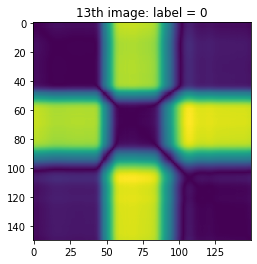

In [25]:
image, label = next(iter(trainloader))  # Get a random batch of 64 images
i = np.random.randint(0, 15)            # Choose one image at random
plt.imshow(image[i, 0])    # Plot
plt.title(f"{i}th image: label = {int(label[i])}");

# Model Training

In [26]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            # X = X.to(device)
            # y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.unsqueeze(1))  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                # X = X.to(device)
                # y = y.to(device)
                y_hat = model(X)  # forward pass to get output
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.unsqueeze(1))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            if (epoch+1) % 100 == 0:
                print(f"Epoch {epoch + 1}:",
                      f"Train Loss: {train_loss[-1]:.3f}.",
                      f"Valid Loss: {valid_loss[-1]:.3f}.",
                      f"Train Accuracy: {train_accuracy[-1]:.2f}."
                      f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
                
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if epoch > 100 and consec_increases == patience:  # Newly added condition for epoch > 100
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
            
    print("\nTraining ended.")
    
    loss_fig = pd.DataFrame({"train_loss": train_loss, "valid_loss": valid_loss}).plot.line()
    loss_fig.set_xlabel('Epoch')
    loss_fig.set_ylabel('Loss');
    
    accur_fig = pd.DataFrame({"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}).plot.line()
    accur_fig.set_xlabel('Epoch')
    accur_fig.set_ylabel('Accuracy');

In [27]:
# # To move the weights which were saved in gpu to cpu (codes from pytorch tutorial)

# PATH = "model.pt"
# torch.save(net.state_dict(), PATH)

# device = torch.device('cpu')
# model = ConvolutionalNeuralNetwork()
# model.load_state_dict(torch.load(PATH, map_location=device))

model.apply(weights_init)

C:\Users\johnw\AppData\Local\Temp\ipykernel_13136\1855755017.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight.data)


ConvolutionalNeuralNetwork(
  (main): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(10, 10), stride=(10, 10), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9, out_features=1, bias=True)
  )
)

In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Epoch 100: Train Loss: 0.355. Valid Loss: 0.351. Train Accuracy: 0.91.Valid Accuracy: 0.88.
Epoch 200: Train Loss: 0.196. Valid Loss: 0.260. Train Accuracy: 0.95.Valid Accuracy: 0.94.
Epoch 300: Train Loss: 0.121. Valid Loss: 0.251. Train Accuracy: 0.98.Valid Accuracy: 0.94.
Epoch 400: Train Loss: 0.080. Valid Loss: 0.265. Train Accuracy: 0.99.Valid Accuracy: 0.92.
Epoch 500: Train Loss: 0.059. Valid Loss: 0.286. Train Accuracy: 0.99.Valid Accuracy: 0.92.
Epoch 600: Train Loss: 0.044. Valid Loss: 0.311. Train Accuracy: 0.99.Valid Accuracy: 0.92.
Stopped early at epoch 610 - val loss increased for 5 consecutive epochs!

Training ended.


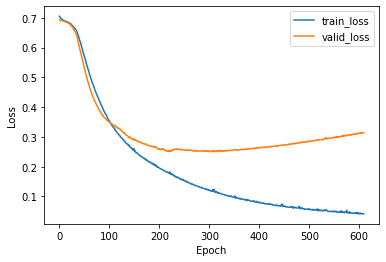

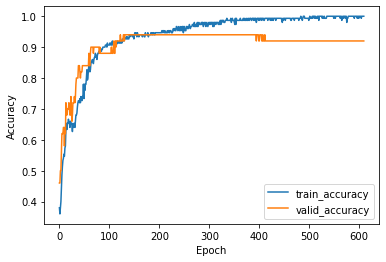

In [29]:
trainer(model, criterion, optimizer, trainloader, validloader, epochs=2000, patience=5, verbose=True)

In [30]:
#torch.save(model.state_dict(), "model_2d_rec_trained.pt")
#model = ConvolutionalNeuralNetwork()
#model.load_state_dict(torch.load("model_2d_rec_trained.pt", map_location=device))

# Prediction

Prbability of being 1: 0.000547


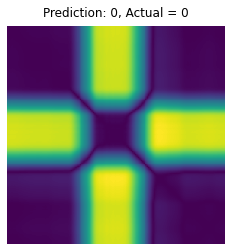

In [31]:
model.eval()
with torch.no_grad():
    img, lab = next(iter(trainloader))
    y_prob = torch.sigmoid(model(img))
    # y_prob = torch.sigmoid(model(img[None, :, :, :][0]))
    y_class = int(y_prob[0] > 0.5)
    print(f"Prbability of being 1: {y_prob[0].item():.3g}")
    
    plt.imshow(img[0].permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Prediction: {['0', '1'][y_class]}, Actual = {int(lab[0])}", pad=10);

# XAI - Occlusion

### 1. Absolute Value

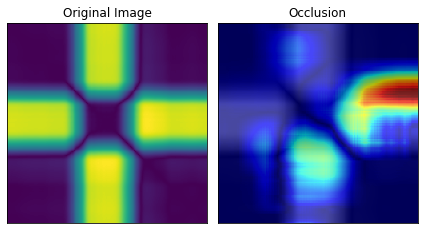

In [32]:
image_tensor = img[0].unsqueeze(0)
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(image_tensor,
                                       strides=(1, 2, 2),
                                       sliding_window_shapes=(1, 25, 25),
                                       baselines=None)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(image_tensor.squeeze(0).detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      titles = ["Original Image", "Occlusion"],
                                      cmap="jet",
                                      fig_size=(6, 6),
                                      alpha_overlay=0.7
                                     )

### 2. Positive

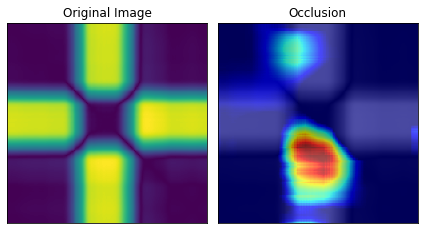

In [33]:
image_tensor = img[0].unsqueeze(0)
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(image_tensor,
                                       strides=(1, 2, 2),
                                       sliding_window_shapes=(1, 25, 25),
                                       baselines=None)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(image_tensor.squeeze(0).detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      titles = ["Original Image", "Occlusion"],
                                      cmap="jet",
                                      fig_size=(6, 6),
                                      alpha_overlay=0.7
                                     )

### 3. Negative

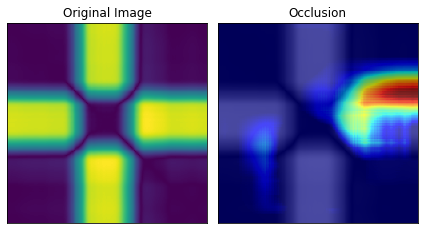

In [34]:
image_tensor = img[0].unsqueeze(0)
occlusion = Occlusion(model)
attributions_occ = occlusion.attribute(image_tensor,
                                       strides=(1, 2, 2),
                                       sliding_window_shapes=(1, 25, 25),
                                       baselines=None)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(image_tensor.squeeze(0).detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "negative"],
                                      titles = ["Original Image", "Occlusion"],
                                      cmap="jet",
                                      fig_size=(6, 6),
                                      alpha_overlay=0.7
                                     )

# XAI - Gradient SHAP

### 1. Absolute Value

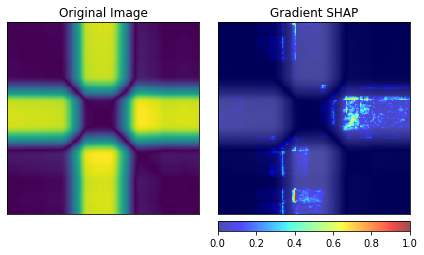

In [35]:
# Gradient SHAP
gradient_shap = GradientShap(model)
rand_img_dist = torch.cat([image_tensor * 0, image_tensor * 1])
attributions_gs = gradient_shap.attribute(image_tensor,
                                          n_samples=1000,
                                          stdevs=0.5,
                                          baselines=rand_img_dist,
                                          target=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(image_tensor.squeeze(0).detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      titles = ["Original Image", "Gradient SHAP"],
                                      cmap="jet",
                                      show_colorbar=True,
                                      fig_size=(6, 6),
                                      alpha_overlay=0.7)

### 2. Positive

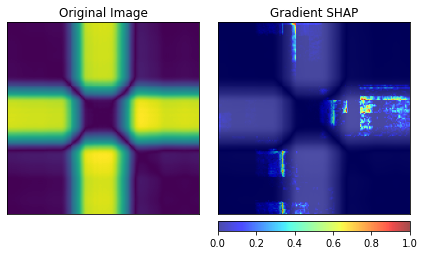

In [36]:
# Gradient SHAP
gradient_shap = GradientShap(model)
rand_img_dist = torch.cat([image_tensor * 0, image_tensor * 1])
attributions_gs = gradient_shap.attribute(image_tensor,
                                          n_samples=1000,
                                          stdevs=0.5,
                                          baselines=rand_img_dist,
                                          target=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(image_tensor.squeeze(0).detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "positive"],
                                      titles = ["Original Image", "Gradient SHAP"],
                                      cmap="jet",
                                      show_colorbar=True,
                                      fig_size=(6, 6),
                                      alpha_overlay=0.7)

### 3. Negative

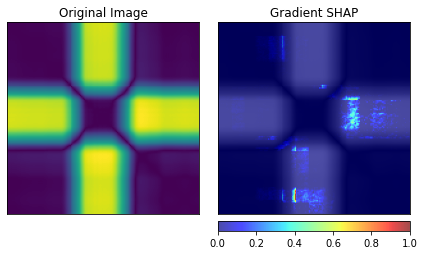

In [37]:
# Gradient SHAP
gradient_shap = GradientShap(model)
rand_img_dist = torch.cat([image_tensor * 0, image_tensor * 1])
attributions_gs = gradient_shap.attribute(image_tensor,
                                          n_samples=1000,
                                          stdevs=0.5,
                                          baselines=rand_img_dist,
                                          target=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze(0).detach().numpy(), (1,2,0)),
                                      np.transpose(image_tensor.squeeze(0).detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "negative"],
                                      titles = ["Original Image", "Gradient SHAP"],
                                      cmap="jet",
                                      show_colorbar=True,
                                      fig_size=(6, 6),
                                      alpha_overlay=0.7)